# EDA

In [7]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import ttest_ind
import matplotlib.image as mpimg

In [8]:
# load data
df = pd.read_csv('df_house.csv', index_col=0)
# change data types
df.id = df.id.astype(str)
df.zipcode = df.zipcode.astype(str)
df.date = pd.to_datetime(df.date)

# 1 Correlation between house price and independent variables

Since many of my variables are skewed (including house price) or ordinal, I will use the Spearman (or Kendal's tau) correlation instead of the Pearson correlation. The Spearman correlation, unlike the Pearson correlation, does not assume that both datasets have normal distributions.

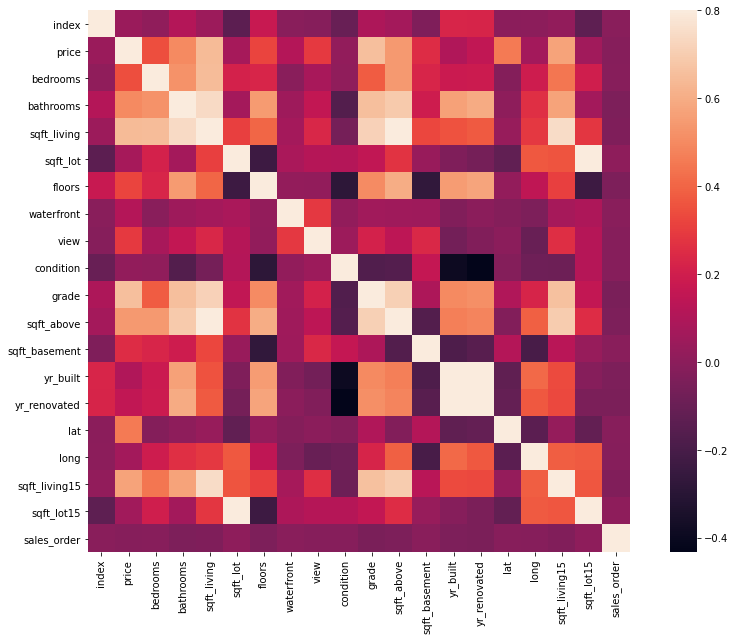

In [9]:
corr_matrix = df.corr(method ='spearman')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=.8, square=True)
plt.tight_layout() # need for savefig
plt.savefig("corr_heat_map.png",format="png", dpi=300)
plt.show()

In [10]:
# Correlations to price
corr_to_price = corr_matrix['price'].sort_values(ascending=False)
corr_to_price

price            1.000000
grade            0.658150
sqft_living      0.643992
sqft_living15    0.572265
sqft_above       0.541562
bathrooms        0.497297
lat              0.456125
bedrooms         0.344176
floors           0.322480
view             0.293910
sqft_basement    0.251490
yr_renovated     0.152822
waterfront       0.115119
yr_built         0.102058
sqft_lot         0.075073
long             0.064060
sqft_lot15       0.063079
index            0.040188
condition        0.017991
sales_order     -0.014741
Name: price, dtype: float64

Independent variables strongly correlated to dependent variable (price)

Here I will assume correlation of two variables is strong if the absolute value of their correlation coefficient is higher than or equal to 0.5.

In [11]:
corr_high = corr_to_price[(corr_to_price >= 0.5)|(corr_to_price <= -0.5)][1:]
corr_high

grade            0.658150
sqft_living      0.643992
sqft_living15    0.572265
sqft_above       0.541562
Name: price, dtype: float64

These are the strongly correlated independent variables to the dependent variable, price.
They are features related to square footage and house grade.

In [12]:
corr_medium = corr_to_price[(corr_to_price >= 0.3)|(corr_to_price <= -0.3)][1:]
corr_medium

grade            0.658150
sqft_living      0.643992
sqft_living15    0.572265
sqft_above       0.541562
bathrooms        0.497297
lat              0.456125
bedrooms         0.344176
floors           0.322480
Name: price, dtype: float64

# 2 Hypothesis test for correlation

I will use the t-test for the population correlation coefficient to check the significance of correlations. Again, I need to use the Spearman (or Kendal's tau) correlation due to skewed or ordinal variables.

Null hypothesis: the population correlation is zero i.e., r=0
Alternative hypothesis: the population correlation is not zero (two-sided) i.e., r!=0

In [13]:
for col in corr_high.index:
    corr, p_val = spearmanr(df[col], df['price'])
    print("Corr:", round(corr,4), "p-val:", p_val, "Price vs.", col)

Corr: 0.6582 p-val: 0.0 Price vs. grade
Corr: 0.644 p-val: 0.0 Price vs. sqft_living
Corr: 0.5723 p-val: 0.0 Price vs. sqft_living15
Corr: 0.5416 p-val: 0.0 Price vs. sqft_above


All correlations are significantly different from zero since the p-values are less than .01, the significance level. Thus, we reject the null hypothesis that two variables have zero correlation. In other words, each of above variable is significantly correlated to house price.

# 3. Correlation between independent variables

Here I will find strongly correlated independent variable pairs. Here I will assume correlation of two variables is strong if the absolute value of their correlation coefficient is higher than or equal to 0.7 since a lower cutoff (like 0.5) output too many pairs of variables. Again, the t-test for the population correlation coefficient (spearman) was used to check the significance of correlations.

In [14]:
corr_indep = pd.DataFrame()
for i, col in enumerate(corr_matrix.index):
    for j, idx in enumerate(corr_matrix.index):
        if i > j:
            corr = corr_matrix.loc[idx,col]
            if  (corr >= .7) | (corr <= -.7):
                _, p_val = spearmanr(df[col], df[idx])
                corr_indep.loc[idx+'_vs_'+col, 'corr'] = round(corr,4)
                corr_indep.loc[idx+'_vs_'+col, 'p_val'] = p_val
                
print(corr_indep.sort_values(by=['corr'], ascending=False)) #df.sort() was deprecated

                                corr  p_val
sqft_lot_vs_sqft_lot15        0.9223    0.0
yr_built_vs_yr_renovated      0.9121    0.0
sqft_living_vs_sqft_above     0.8433    0.0
sqft_living_vs_sqft_living15  0.7470    0.0
bathrooms_vs_sqft_living      0.7459    0.0
sqft_living_vs_grade          0.7163    0.0
grade_vs_sqft_above           0.7117    0.0


These are highly correlated (>= 0.7 or <=-0.7) pairs of independent variables and their correlation coefficients are all significantly different from zero (p-value < .01).
The top three pairs, who have around 0.9 of correlation, are sqft_lot and sqft_lot15, yr_built and yr_renovated, and sqft living and sqft above.
    The first top pair is expected since lot size of a house usually does not change over time.
    The second top pair yr_built and yr_renovated are correlated since I made yr_renovated using yr_built.
    The third top pair shows sqft living vs sqft above.

# 4. Relationship between house price and categorical independent variables

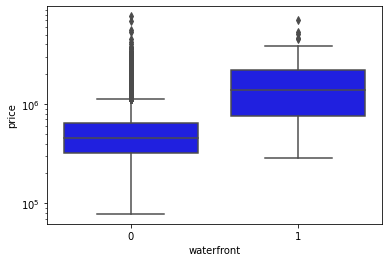

In [15]:
# boxplot for waterfront vs. price (in log scale)
g = sns.boxplot(x='waterfront', y='price', data = df, color="blue")
g.set_yscale('log') #needed this due to skewed prices
plt.show()

I found waterfront houses tend to be more expensive than others using a boxplot (above), a scatter plot and a map plot in the storytelling part of this project. Here I will test if prices of waterfront and not waterfront houses are significantly different using a hypothesis test.

In [16]:
def print_result(outputs, title, label_1='test statistic', 
                 label_2='p-value', digits = 4):
    print(title)
    print(label_1, ": ", round(outputs[0],digits))
    print(label_2, ": ", round(outputs[1],digits))

In [17]:
# sample means
price_not_waterfront = df.price[df.waterfront == 0]
price_waterfront = df.price[df.waterfront == 1]
print("Not waterfront")
print("Sample size:", len(price_not_waterfront), "Mean:", round(np.mean(price_not_waterfront)))
print("Waterfront")
print("Sample size:", len(price_waterfront), "Mean:", round(np.mean(price_waterfront)))

Not waterfront
Sample size: 21434 Mean: 531673
Waterfront
Sample size: 163 Mean: 1661876


In [18]:
print('proportion of waterfront houses: {:.2f} %'.format(sum(df.waterfront)/len(df)*100))

proportion of waterfront houses: 0.75 %


In [19]:
# two sample independent t-test (two-sided)
output_t = ttest_ind(price_not_waterfront, price_waterfront, equal_var=False) #Welch’s t-test
print_result(output_t,"two-sample independent t-test", digits=4)

two-sample independent t-test
test statistic :  -12.8746
p-value :  0.0


The p-vluae is closed to zero (less than 0.01), so we reject the null hypothesis that two population means are the same. Therefore, I conclude that waterfront houses are significantly more expensive than not waterfront houses.

# 5. Conclusion

For correlation, I used spearman correlation coefficients due to skewed or ordinal variables. Statistical significance of correlation was tested with the t-test for the population correlation coefficients.

I found the variables strongly and significantly correlated to house prices are features related to house locations square footage of house (sqft_living, sqft_above, and sqft_living15, but not sqft_basement), and house grade. These will be good predictors for a house price prediction model if high correlations between independent variables (multicolinearity) is well taken care of.

Many independent variables are highly and significantly correlated; 10 pairs have correlation over 0.7. The Highly correlated independent variable will be carefully treated in my house prediction models to avoid multicolinearity.

A two-sample independent t-test was used to find a significant categorical variable in a house price prediction. I used Welch’s t-test which does not assume equal variance or equal sample size in two populations. I had to use it because the two groups in my categorical variables have very unbalanced sample sizes.

I found waterfront houses are significantly more expensive than not waterfront houses.